## 1. 영어 Word2Vec 만들기

In [1]:
import nltk
#nltk.download('punkt')
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

### 1) 훈련 데이터 이해하기

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="../Data/ted_en-20160408.xml")

('../Data/ted_en-20160408.xml', <http.client.HTTPMessage at 0x216c803c340>)

> 실질적 데이터는 영어문장으로만 구성된 내용을 담고 있는 \<content>와 \</content> 사이의 내용  

> 전처리 작업을 통해 xml 문법들은 제거하고, 해당 데이터만 가져와야 함.  

> \<content>와 \</content> 사이의 내용 중에는 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어도 등장하는데 이 또한 제거해야 함.

### 2) 훈련 데이터 전처리하기

In [3]:
targetXML=open('../Data/ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져옴.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [4]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### 3) Word2Vec 훈련시키기

- Word2Vec의 하이퍼파라미터값  
\- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.    
\- window = 컨텍스트 윈도우 크기  
\- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않음.)  
\- workers = 학습을 위한 프로세스 수  
\- sg = 0은 CBOW, 1은 Skip-gram.  

In [5]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

# man과 가장 유사한 단어
model_result = model.wv.most_similar("man")
print(model_result)

C:\Users\colin\anaconda3\envs\DH\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[('woman', 0.859266996383667), ('guy', 0.7881397008895874), ('lady', 0.7790858745574951), ('boy', 0.7541667819023132), ('girl', 0.7385468482971191), ('gentleman', 0.7167842388153076), ('poet', 0.6855091452598572), ('soldier', 0.6799006462097168), ('kid', 0.6787206530570984), ('philosopher', 0.6693777441978455)]


> man과 유사한 단어로 woman, guy, boy, lady, girl, gentleman, soldier, kid 등을 출력

###  4) Word2Vec 모델 저장하고 로드하기

In [6]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

# 로드한 모델에 대해서 다시 man과 유사한 단어를 출력
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.859266996383667), ('guy', 0.7881397008895874), ('lady', 0.7790858745574951), ('boy', 0.7541667819023132), ('girl', 0.7385468482971191), ('gentleman', 0.7167842388153076), ('poet', 0.6855091452598572), ('soldier', 0.6799006462097168), ('kid', 0.6787206530570984), ('philosopher', 0.6693777441978455)]


## 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

### 1) 훈련 데이터 이해하기

In [8]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="../Data/ratings.txt")
train_data = pd.read_table('../Data/ratings.txt')
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [9]:
print(len(train_data)) # 리뷰 개수 출력

200000


> 리뷰 개수 : 200000개

### 2) 훈련 데이터 전처리하기

In [10]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [11]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [12]:
print(len(train_data)) # 리뷰 개수 출력

199992


> 결측치 처리 후 리뷰 개수 : 199992개

In [13]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5] # 상위 5개 출력

<ipython-input-13-445056d3ef32>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [14]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


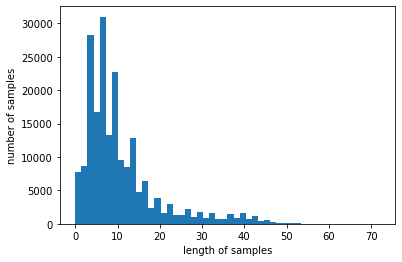

In [15]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 3) Word2Vec 훈련시키기

- Word2Vec의 하이퍼파라미터값  
\- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.    
\- window = 컨텍스트 윈도우 크기  
\- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않음.)  
\- workers = 학습을 위한 프로세스 수  
\- sg = 0은 CBOW, 1은 Skip-gram.  

In [16]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [17]:
# "최민식"과 가장 유사한 단어
print(model.wv.most_similar("최민식"))

[('한석규', 0.8531435132026672), ('김수현', 0.8426737785339355), ('송강호', 0.8424169421195984), ('안성기', 0.842138409614563), ('설경구', 0.8322974443435669), ('서영희', 0.831502377986908), ('이민호', 0.8192241787910461), ('크로우', 0.8191364407539368), ('이정재', 0.8154851198196411), ('김명민', 0.8138096332550049)]


In [18]:
# "히어로"와 가장 유사한 단어
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8559202551841736), ('느와르', 0.8528561592102051), ('호러', 0.8490641713142395), ('물의', 0.8398354053497314), ('무협', 0.8397684693336487), ('로코', 0.8229196667671204), ('정통', 0.8173826932907104), ('물', 0.81407231092453), ('블록버스터', 0.8132748603820801), ('고어', 0.812898576259613)]
